<a href="https://colab.research.google.com/github/H-Gallagher/DDoS-Detection-using-Machine-Learning/blob/main/DDoS_detection_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*****  
# **The use of Machine Learning algorithms for the detection of DDoS attacks**      
*****  
*'Open in Colab' reccomended for better navigation.*     
The following notebook investigates and evaluates the use of Machine Learning algorithms for the detection of DDoS attacks.       
The datasets used are CIC-DDoS2019 and CIC-IDS2017 which are linked in section 1 below.

# **(i): Load required packages.**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, average_precision_score, make_scorer, roc_auc_score

*****  
# **1: Read in the dataset and inspect**.      
*****  

#### CIC-DDoS2019 Datasets.     
The primary datasets used 'DDoS_combined_train' and 'DDoS_combined_test' contain a combination of attacks found in the full CIC-DDoS2019 Datasets. The code used for combining the datasets can be found in the repository 'CIC_DDoS2019_Combine_Attack_Datasets.ipynb', while the CIC-DDoS2019 dataset is available here: https://www.unb.ca/cic/datasets/ddos-2019.html 

In [2]:
# Training Day. Combined from individual attacks. CIC-DDoS2019.
ddos_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CT5108_Data_Analytics_Project/data/CICDDoS2019/DDoS_combined_train.csv", header=0, sep=",", skipinitialspace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Testing Day. Combined from individual attacks. CIC-DDoS2019.
ddos_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CT5108_Data_Analytics_Project/data/CICDDoS2019/DDoS_combined_test.csv", header=0, sep=",", skipinitialspace=True)

#### CIC-IDS2017 Datasets.       
For a more full evaluation, data from the CIC-IDS2017 dataset was also used. From it 'slow_dos_IDS2017' which contains slowloris and slowhttp attacks was used as well as 'benign_IDS2017' which contains benign data only. The full CIC-IDS2017 dataset is available here: https://www.unb.ca/cic/datasets/ids-2017.html 

In [4]:
# Read in Wednesday DoS dataset. Contains slowloris and slowhttp attacks.
slow_dos_IDS2017 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CT5108_Data_Analytics_Project/data/CIC_IDS2017/DoS_DDoS_Wednesday-workingHours.pcap_ISCX.csv", 
                               header=0, sep=",", skipinitialspace=True)

In [5]:
# Read in Monday dataset. Benign data only.
benign_IDS2017 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CT5108_Data_Analytics_Project/data/CIC_IDS2017/Benign_Monday-WorkingHours.pcap_ISCX.csv", 
                              header=0, sep=",", skipinitialspace=True)

## Set maximum column and row view.

In [6]:
# Set max rows and columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 8)  # Set to None to show all rows.

## Preview Data

In [7]:
# Preview ddos_combined_train data.
ddos_train.head(3)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,99007,192.168.50.7-4.2.2.4-56938-53-17,192.168.50.7,56938,4.2.2.4,53,17,2018-12-01 12:49:29.926102,20980,2,2,70.0,126.0,35.0,35.0,35.000000,0.000000,63.0,63.0,63.000000,0.000000,9342.230696,190.657769,6.993333e+03,1.209722e+04,20962.0,2.0,16.0,16.00,0.000000e+00,16.0,16.0,2.0,2.0,0.000000e+00,2.0,2.0,0,0,0,0,40,40,95.328885,95.328885,35.0,63.0,46.2,15.336232,235.200000,0,0,0,0,0,0,0,0,1.0,57.750000,35.000000,63.000000,40,0,0,0,0,0,0,2,70,2,126,-1,-1,1,20,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,BENIGN
1,524,172.217.10.34-192.168.50.6-443-57720-6,192.168.50.6,57720,172.217.10.34,443,6,2018-12-01 12:50:14.147921,118411794,26,21,1834.0,6014.0,517.0,0.0,70.538462,140.928132,2524.0,0.0,286.380952,635.303193,66.277182,0.396920,2.574169e+06,1.216863e+07,59110362.0,0.0,118411794.0,4736471.76,1.634866e+07,59172359.0,0.0,118349876.0,5917493.8,1.818260e+07,59151993.0,0.0,0,0,0,0,544,444,0.219573,0.177347,0.0,2524.0,163.5,440.918673,194409.276596,0,0,0,0,1,0,0,0,0.0,166.978723,70.538462,286.380952,544,0,0,0,0,0,0,26,1834,21,6014,8192,246,12,20,148754.5,105628.31808,223445.0,74064.0,59026175.0,119058.397176,59110362.0,58941988.0,0,0,BENIGN
2,83486,192.168.10.50-192.168.50.7-22-52102-6,192.168.50.7,52102,192.168.10.50,22,6,2018-12-01 12:55:05.144744,2,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1000000.000000,2.000000e+00,0.000000e+00,2.0,2.0,2.0,2.00,0.000000e+00,2.0,2.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,64,0,1000000.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,64,0,0,0,0,0,0,2,0,0,0,64240,-1,0,32,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,BENIGN


In [8]:
# Preview ddos_combined_test data.
ddos_test.head(3)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,616,192.168.50.9-69.172.216.111-56014-443-6,192.168.50.9,56014,69.172.216.111,443,6,2018-11-03 10:13:31.240340,5797934,13,8,1334.0,304.0,585.0,0.0,102.615385,214.997108,152.0,0.0,38.0,70.362328,282.514427,3.621980,289896.7,1.269031e+06,5680993.0,1.0,5797934.0,483161.166667,1.657303e+06,5745715.0,1.0,91849.0,13121.285714,24882.086017,64932.0,2.0,0,0,0,0,432,272,2.242178,1.379802,0.0,585.0,74.454545,171.245501,29325.021645,0,0,0,0,1,0,0,0,0.0,78.000000,102.615385,38.0,432,0,0,0,0,0,0,13,1334,8,304,29200,59,6,32,116937.0,0.0,116937.0,116937.0,5680993.0,0.0,5680993.0,5680993.0,0,0,BENIGN
1,29556,192.168.50.9-23.194.142.213-58476-443-6,192.168.50.9,58476,23.194.142.213,443,6,2018-11-03 10:24:19.696993,1061308,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,5.653401,212261.6,4.562243e+05,1027972.0,1.0,1027974.0,342658.000000,5.934993e+05,1027972.0,1.0,1.0,1.000000,0.000000,1.0,1.0,0,0,0,0,128,64,3.768934,1.884467,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,1,0,0,0.0,0.000000,0.000000,0.0,128,0,0,0,0,0,0,4,0,2,0,521,631,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN
2,2,192.168.50.6-74.208.236.171-55486-80-6,192.168.50.6,55486,74.208.236.171,80,6,2018-11-03 10:24:54.360887,105980,7,2,1014.0,0.0,498.0,0.0,144.857143,241.257420,0.0,0.0,0.0,0.000000,9567.842989,84.921683,13247.5,2.513397e+04,66253.0,1.0,105980.0,17663.333333,2.819655e+04,66413.0,1.0,2.0,2.000000,0.000000,2.0,2.0,0,0,0,0,164,64,66.050198,18.871485,0.0,498.0,101.400000,209.044493,43699.600000,0,0,0,0,1,0,0,0,0.0,112.666667,144.857143,0.0,164,0,0,0,0,0,0,7,1014,2,0,8192,29200,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ar.drshno.com/wp-content/themes/enfold/config-...,0,BENIGN


In [9]:
# Preview slow_dos_IDS2017 data.
slow_dos_IDS2017.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,6,6,6.0,0.000000,3.132505e+02,52.208416,38308.000000,0.000000,38308,38308,0,0.000000,0.000000,0,0,0,0.00,0.000000,0,0,0,0,0,0,20,20,26.104208,26.104208,6,6,6.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,9.000,6.000000,6.0,20,0,0,0,0,0,0,1,6,1,6,255,946,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,163,0,65.2,89.278777,1.039666e+06,33402.922760,31.933333,25.510409,73,0,479,47.900000,38.942836,109,1,401,100.25,101.736178,237,3,0,0,0,0,368,176,22964.509390,10438.413360,0,163,29.294118,56.529599,3195.595588,0,0,0,1,0,0,0,0,0,31.125,15.636364,65.2,368,0,0,0,0,0,0,11,172,5,326,29200,260,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,1575,0,525.0,813.326503,5.753425e+06,14611.872150,73.000000,204.960972,810,1,1095,121.666667,298.746130,915,1,995,199.00,345.535092,810,3,0,0,0,0,336,208,9132.420091,5479.452055,0,1575,370.588235,671.751541,451250.132400,0,0,0,1,0,0,0,0,0,393.750,315.000000,525.0,336,0,0,0,0,0,0,10,3150,6,3150,29200,2081,3,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
# Preview benign_IDS2017 data.
benign_IDS2017.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,3000000.0,500000.0,4.0,0.0,4,4,4,4.0,0.0,4,4,0,0.0,0.0,0,0,0,0,0,0,40,0,500000.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2000000.0,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2000000.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2000000.0,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2000000.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Inspect shape and value counts

In [11]:
# Check shape of training and test sets.
print("DDoS_combined_train:", ddos_train.shape)
print("DDoS_combined_test:    ", ddos_test.shape)

DDoS_combined_train: (676989, 88)
DDoS_combined_test:     (278833, 88)


In [12]:
# DDoS_combined_train value counts
print(ddos_train.Label.value_counts())

DrDoS_LDAP       65398
DrDoS_NetBIOS    63446
Syn              63292
DrDoS_SNMP       62951
                 ...  
DrDoS_MSSQL      58792
UDP-lag          58634
BENIGN            1727
WebDDoS             70
Name: Label, Length: 13, dtype: int64


In [13]:
# DDoS_combined_test value counts. 
# NOTE: Attacks in original 'UDP Lag' dataset were mostly labelled as 'Syn'. 
print(ddos_test.Label.value_counts())

Syn        71934
UDP        47487
NetBIOS    45310
MSSQL      38383
Portmap    37392
LDAP       36547
BENIGN      1677
UDPLag       103
Name: Label, dtype: int64


In [14]:
# slow_dos_IDS2017 value counts.
print(slow_dos_IDS2017.Label.value_counts())

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64


In [15]:
# benign_IDS2017 value counts.
print(benign_IDS2017.Label.value_counts())

BENIGN    529918
Name: Label, dtype: int64


## Inspect dtypes

In [16]:
# DDoS_combined_train check dtypes.
ddos_train.dtypes.value_counts()

float64    45
int64      37
object      6
dtype: int64

In [17]:
# DDoS_combined_test check dtypes.
ddos_test.dtypes.value_counts()

float64    45
int64      37
object      6
dtype: int64

In [18]:
# slow_dos_IDS2017 value counts.
print(slow_dos_IDS2017.dtypes.value_counts())

int64      54
float64    24
object      1
dtype: int64


In [19]:
# benign_IDS2017 value counts.
print(benign_IDS2017.dtypes.value_counts())

int64      54
float64    24
object      1
dtype: int64


## Set Seed

In [20]:
# Set seed for reproducibility.
np.random.seed(17)
seed = int(np.random.randint(1, 100, size=1)) 

*****  
# **2: Preprocessing & EDA.**
*****  

## 2.1 Preprocessing

### Inspect infs, NaNs      
The observations which contain NaN values also contain infinity values. For some observations, multiple features contain infinity values.

In [21]:
# Inspect infinity values.
numeric = ["int64", "float64"]
inf_train = ddos_train.select_dtypes(include=numeric)  # Select numeric columns.
inf_test = ddos_test.select_dtypes(include=numeric)

inf_train = inf_train[(inf_train == np.inf).any(axis=1)]  # Select rows containing infinity values.
inf_test = inf_test[(inf_test == np.inf).any(axis=1)] 

print("Infinity values in ddos_train:", np.isinf(inf_train).values.sum())
print("Infinity values in ddos_test:    ", np.isinf(inf_test).values.sum())

Infinity values in ddos_train: 35479
Infinity values in ddos_test:     25133


In [22]:
# Inspect NaN values.
nan_train = ddos_train[ddos_train.isna().any(axis=1)]
nan_test = ddos_test[ddos_test.isna().any(axis=1)]

print("NaN values in ddos_train:", nan_train.isna().sum().sum())
print("NaN values in ddos_test:   ", nan_test.isna().sum().sum())

NaN values in ddos_train: 14563
NaN values in ddos_test:    3


In [23]:
# Compare if inf and NaN values present in same rows of training set.
inf_train_index = list(inf_train.index)
nan_train_index = list(nan_train.index)

print("Train: Number of rows with inf values", len(inf_train))
print("Train: Number of rows with NaN values", len(nan_train))
print("Train: Number of rows with NaN and inf values:", sum(i in inf_train_index for i in nan_train_index))

Train: Number of rows with inf values 25021
Train: Number of rows with NaN values 14563
Train: Number of rows with NaN and inf values: 14563


In [24]:
# Compare if inf and NaN values present in same rows of test set.
inf_test_index = list(inf_test.index)
nan_test_index = list(nan_test.index)

print("Test: Number of rows with inf values", len(inf_test))
print("Test: Number of rows with NaN values", len(nan_test))
print("Test: Number of rows with NaN and inf values:", sum(i in inf_test_index for i in nan_test_index))

Test: Number of rows with inf values 12568
Test: Number of rows with NaN values 3
Test: Number of rows with NaN and inf values: 3


### Remove infs, NaNs    
For the slow_dos_IDS2017 dataset, as only the slowloris and slowhttp attack types are required, the other attacks are converted to nan values and removed at this point.

In [25]:
# https://stackoverflow.com/questions/45745085/python-pandas-how-to-remove-nan-and-inf-values

# Train: Replace 'inf' values with nan and drop.
ddos_train = ddos_train.replace([np.inf, -np.inf], np.nan)
ddos_train = ddos_train.dropna()
ddos_train = ddos_train.reset_index(drop=True)

# Test:  Replace 'inf' values with nan and drop.
ddos_test = ddos_test.replace([np.inf, -np.inf], np.nan)
ddos_test = ddos_test.dropna()
ddos_test = ddos_test.reset_index(drop=True)


In [26]:
# Slow_Dos: Replace 'inf' values with nan and drop.
slow_dos_IDS2017 = slow_dos_IDS2017.replace([np.inf, -np.inf, "DoS Hulk", "DoS GoldenEye", "Heartbleed"], np.nan)
slow_dos_IDS2017 = slow_dos_IDS2017.dropna()
slow_dos_IDS2017 = slow_dos_IDS2017.reset_index(drop=True)

# Benign: Replace 'inf' values with nan and drop.
benign_IDS2017 = benign_IDS2017.replace([np.inf, -np.inf], np.nan)
benign_IDS2017 = benign_IDS2017.dropna()
benign_IDS2017 = benign_IDS2017.reset_index(drop=True)

### Remove features
Remove structural and duplicate features not mentioned in list below.             
Ensures features used are the same for the CIC-DDoS2019 and CIC-IDS2017 datasets.

List of features extracted from PCAP file:         
https://github.com/CanadianInstituteForCybersecurity/CICFlowMeter/blob/master/ReadMe.txt        

In [27]:
# Remove structural and duplicate features.
ddos_train = ddos_train.drop(["Unnamed: 0", "Flow ID", "Source IP", "Source Port",  "Destination IP", "Destination Port", 
                              "Protocol", "Timestamp", "SimillarHTTP", "Fwd Header Length.1", "Inbound"], axis=1)

ddos_test = ddos_test.drop(["Unnamed: 0", "Flow ID", "Source IP", "Source Port",  "Destination IP", "Destination Port", 
                            "Protocol", "Timestamp", "SimillarHTTP", "Fwd Header Length.1", "Inbound"], axis=1)

In [28]:
# CIC-IDS2017: Remove features.
slow_dos_IDS2017 = slow_dos_IDS2017.drop(["Destination Port", "Fwd Header Length.1"], axis=1)
benign_IDS2017 = benign_IDS2017.drop(["Destination Port", "Fwd Header Length.1"], axis=1)

In [29]:
# Inspect shape of reduced dataframes.
print("DDoS_combined_train:", ddos_train.shape)
print("DDoS_combined_test: ", ddos_test.shape)
print("slow_dos_IDS2017:   ", slow_dos_IDS2017.shape)
print("benign_IDS2017:     ", benign_IDS2017.shape)

DDoS_combined_train: (651968, 77)
DDoS_combined_test:  (266265, 77)
slow_dos_IDS2017:    (450978, 77)
benign_IDS2017:      (529481, 77)


### Encode class labels       
As this is being treated as a binary classification problem, attack labels are converted to 1 and benign labels are converted to 0.

In [30]:
# DDoS_Train: Get list of attack types.
attack_classes = list(ddos_train["Label"].unique())
attack_classes.remove("BENIGN")
print(attack_classes)

['DrDoS_UDP', 'DrDoS_DNS', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_NTP', 'DrDoS_SSDP', 'Syn', 'TFTP', 'UDP-lag', 'WebDDoS']


In [31]:
# DDoS_Train: Convert class labels to binary.
ddos_train["Label"] = ddos_train["Label"].replace(["BENIGN"], 0)
ddos_train["Label"] = ddos_train["Label"].replace(attack_classes, 1)

print(ddos_train.Label.value_counts())  # Normalize = True to get percentage.

1    650249
0      1719
Name: Label, dtype: int64


In [32]:
# DDoS_Test: Get list of attack types.
attack_classes_test = list(ddos_test["Label"].unique())
attack_classes_test.remove("BENIGN")
print(attack_classes_test)

['LDAP', 'NetBIOS', 'MSSQL', 'Portmap', 'Syn', 'UDP', 'UDPLag']


In [33]:
# DDoS_Test: Convert class labels to binary.
ddos_test["Label"] = ddos_test["Label"].replace(["BENIGN"], 0)
ddos_test["Label"] = ddos_test["Label"].replace(attack_classes_test, 1)

print(ddos_test.Label.value_counts())

1    264605
0      1660
Name: Label, dtype: int64


In [34]:
# slow_dos: Get list of attack types.
attack_classes = list(slow_dos_IDS2017["Label"].unique())
attack_classes.remove("BENIGN")
print(attack_classes)

['DoS slowloris', 'DoS Slowhttptest']


In [35]:
# slow_dos: Convert class labels to binary.
slow_dos_IDS2017["Label"] = slow_dos_IDS2017["Label"].replace(["BENIGN"], 0)
slow_dos_IDS2017["Label"] = slow_dos_IDS2017["Label"].replace(attack_classes, 1)

print(slow_dos_IDS2017.Label.value_counts())

0    439683
1     11295
Name: Label, dtype: int64


In [36]:
# Benign: Convert class labels to binary.
benign_IDS2017["Label"] = benign_IDS2017["Label"].replace(["BENIGN"], 0)

print(benign_IDS2017.Label.value_counts())

0    529481
Name: Label, dtype: int64


## **2.2: Exploratory Data Analysis.**

### Descriptive Statistics

In [37]:
# DDoS_train: View statistical summaries.
ddos_train.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,6.519680e+05,651968.000000,651968.000000,651968.000000,6.519680e+05,651968.000000,651968.00000,651968.000000,651968.000000,651968.000000,651968.000000,651968.000000,651968.000000,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,651968.000000,651968.000000,651968.0,651968.0,651968.0,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,651968.000000,651968.000000,651968.000000,651968.000000,6.519680e+05,651968.0,651968.000000,651968.000000,651968.0,651968.000000,651968.000000,651968.000000,651968.0,651968.000000,651968.000000,651968.000000,651968.000000,651968.0,651968.0,651968.0,651968.0,651968.0,651968.0,651968.000000,651968.000000,651968.000000,6.519680e+05,651968.000000,651968.000000,651968.000000,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,6.519680e+05,651968.000000
mean,1.598740e+06,9.207145,0.081052,4045.808882,2.269346e+01,611.108116,597.05168,606.678112,5.488156,1.197991,0.131825,0.358892,0.315899,7.630944e+08,1.128073e+06,2.261390e+05,3.422450e+05,7.325776e+05,1.485516e+02,1.597032e+06,2.391882e+05,3.495308e+05,7.315387e+05,1.435458e+02,8.913845e+04,2.097791e+04,3.690650e+04,7.146895e+04,0.120543,0.000327,0.0,0.0,0.0,-1.496907e+08,-9.778400e+03,1.127609e+06,4.632613e+02,596.988395,611.856471,606.415199,5.483377,5.147582e+02,0.0,0.000037,0.000327,0.0,0.166849,0.001515,0.000953,0.0,0.020460,872.441281,606.678112,0.358892,0.0,0.0,0.0,0.0,0.0,0.0,9.207145,4045.808882,0.081052,2.269346e+01,1003.647299,10.373831,7.326258,-4.204179e+07,9.107334e+02,8.080573e+02,2.018552e+03,4.516741e+02,4.301205e+05,9.397611e+04,5.377721e+05,3.470692e+05,0.997363
std,9.683624e+06,223.683970,2.777083,11811.792205,7.691420e+03,532.670652,539.64398,534.308957,18.642980,77.657096,5.367923,14.695879,16.211720,1.006910e+09,9.101295e+05,1.070368e+06,1.622212e+06,3.712240e+06,6.109215e+04,9.681145e+06,1.141493e+06,1.668130e+06,3.708824e+06,6.108949e+04,2.448157e+06,5.924943e+05,1.029515e+06,1.938575e+06,2.168339,0.018072,0.0,0.0,0.0,2.882711e+09,4.559269e+06,9.106146e+05,7.797835e+03,539.601679,537.037781,534.391194,22.015712,2.750945e+04,0.0,0.006067,0.018072,0.0,0.372841,0.038899,0.030848,0.0,0.153881,816.293972,534.308957,14.695879,0.0,0.0,0.0,0.0,0.0,0.0,223.683970,11811.792205,2.777083,7.691420e+03,2537.925177,643.182185,26.994352,2.071629e+08,5.130899e+04,3.745862e+04,8.607162e+04,4.257677e+04,2.907238e+06,8.604643e+05,3.661397e+06,2.462603e+06,0.051280
min,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e

In [38]:
# DDoS_test: View statistical summaries.
ddos_test.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2.662650e+05,266265.000000,266265.000000,266265.000000,2.662650e+05,266265.000000,266265.000000,266265.000000,266265.000000,266265.000000,266265.000000,266265.000000,266265.000000,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,266265.000000,266265.000000,266265.0,266265.0,266265.0,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,266265.000000,266265.000000,266265.000000,266265.000000,2.662650e+05,266265.0,266265.000000,266265.000000,266265.0,266265.000000,266265.000000,266265.000000,266265.0,266265.000000,266265.000000,266265.000000,266265.000000,266265.0,266265.0,266265.0,266265.0,266265.0,266265.0,266265.000000,266265.000000,266265.000000,2.662650e+05,266265.000000,266265.000000,266265.000000,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,2.662650e+05,266265.000000
mean,1.628262e+06,3.028975,0.463876,936.952052,2.490585e+02,412.166492,405.979021,408.493426,3.043880,2.658239,0.866419,1.334386,0.539125,6.436396e+08,1.286014e+06,1.431658e+05,2.396169e+05,6.378111e+05,3.923408e+02,1.625991e+06,1.901041e+05,2.649095e+05,6.365754e+05,3.895217e+02,6.073009e+05,1.193003e+05,2.053100e+05,4.363045e+05,0.445500,0.000946,0.0,0.0,0.0,-6.046929e+07,-7.972844e+03,1.283948e+06,2.066116e+03,405.966267,413.279027,408.311300,3.210306,4.122702e+02,0.0,0.000079,0.000946,0.0,0.251644,0.002982,0.001502,0.0,0.092615,602.888488,408.493426,1.334386,0.0,0.0,0.0,0.0,0.0,0.0,3.028975,936.952052,0.463876,2.490585e+02,1499.679781,19.491905,1.650040,-2.949229e+07,4.461460e+03,6.478115e+03,1.311891e+04,7.890080e+02,4.658322e+05,1.410728e+05,6.215052e+05,3.323719e+05,0.993766
std,9.407800e+06,172.998167,61.482508,1171.602239,1.132533e+05,459.627100,459.470099,459.031807,14.971332,63.922992,5.211692,20.390985,18.902230,9.094339e+08,9.110971e+05,8.448154e+05,1.383870e+06,3.725960e+06,1.117695e+05,9.406497e+06,1.084248e+06,1.528572e+06,3.725412e+06,1.118110e+05,5.446354e+06,1.067439e+06,1.849635e+06,3.845309e+06,3.971883,0.030750,0.0,0.0,0.0,3.666200e+08,4.118996e+06,9.137981e+05,1.178402e+04,459.463622,461.950388,459.014314,20.049082,1.361508e+04,0.0,0.008880,0.030750,0.0,0.433959,0.054526,0.038730,0.0,0.303079,690.358021,459.031807,20.390985,0.0,0.0,0.0,0.0,0.0,0.0,172.998167,1171.602239,61.482508,1.132533e+05,2711.010066,873.857572,36.448865,1.745686e+08,9.053161e+04,1.108659e+05,2.183694e+05,6.123019e+04,2.841332e+06,9.945051e+05,3.722287e+06,2.223902e+06,0.078712
min,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### Correlations

In [39]:
# DDoS_train correlations.
ddos_train.corr()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Flow Duration,1.000000,0.002878,0.087238,-0.045626,0.009744,-0.153940,-0.151720,-0.155537,-0.014438,0.053729,-0.003625,0.038876,0.061952,-0.125120,-0.204631,0.845776,0.802799,0.881629,0.005909,0.999791,0.863425,0.804532,0.881694,0.005922,0.343703,0.322673,0.327956,0.340236,0.090573,0.013913,NaN,NaN,NaN,0.005057,0.000351,-0.204438,-0.009807,-0.151713,-0.147886,-0.155118,0.005076,0.019782,NaN,-0.000800,0.013913,NaN,0.277662,0.005807,-0.003986,NaN,-0.012190,-0.151749,-0.155537,0.038876,NaN,NaN,NaN,NaN,NaN,NaN,0.002878,-0.045626,0.087238,0.009744,0.258022,0.012830,-0.035737,0.012931,0.090732,0.167136,0.167635,0.030741,0.803350,0.769811,0.875329,0.694820,-0.043143
Total Fwd Packets,0.002878,1.000000,0.019052,0.118885,0.004068,-0.012873,-0.014479,-0.012885,0.007459,0.002741,-0.000784,0.002615,0.002547,-0.023545,-0.037682,-0.001564,-0.001773,-0.000610,-0.000079,0.002882,-0.001433,-0.001703,-0.000604,-0.000076,0.007789,0.002583,0.003069,0.005272,-0.001222,-0.000351,NaN,NaN,NaN,-0.012272,0.000069,-0.037646,-0.001930,-0.014477,-0.012451,-0.012824,0.007627,0.002985,NaN,-0.000171,-0.000351,NaN,-0.012391,-0.001181,-0.001109,NaN,-0.003984,-0.018489,-0.012885,0.002615,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.118885,0.019052,0.004068,-0.010238,-0.000354,0.119637,0.003369,0.000817,0.000908,0.001050,0.000267,-0.000376,0.000354,-0.000045,-0.000650,0.000476
Total Backward Packets,0.087238,0.019052,1.000000,-0.005849,0.913816,-0.021529,-0.032104,-0.031423,0.076414,0.684119,0.017259,0.555341,0.513911,-0.022117,-0.035455,0.033316,0.045071,0.090025,-0.000036,0.086709,0.045006,0.052803,0.089543,-0.000057,0.172098,0.065890,0.077052,0.114971,0.042630,0.019888,NaN,NaN,NaN,0.001513,-0.001470,-0.035785,0.040789,-0.032192,0.066816,-0.021886,0.369491,0.766527,NaN,0.002372,0.019888,NaN,0.058938,0.030342,0.020996,NaN,0.155406,-0.023774,-0.031423,0.555341,NaN,NaN,NaN,NaN,NaN,NaN,0.019052,-0.005849,1.000000,0.913816,0.147491,0.039846,-0.002999,0.005906,0.084397,0.060652,0.081879,0.048945,0.075889,0.046477,0.073924,0.073682,-0.150729
Total Length of Fwd Packets,-0.045626,0.118885,-0.005849,1.000000,0.000201,0.014506,0.001143,0.014818,0.046859,0.000138,-0.006796,-0.002922,-0.000154,-0.100497,-0.264284,-0.056610,-0.056620,-0.053608,-0.000747,-0.045584,-0.056893,-0.056410,-0.053568,-0.000719,-0.008662,-0.011752,-0.011533,-0.010663,-0.018940,-0.005590,NaN,NaN,NaN,-0.103666,0.000722,-0.263969,-0.020315,0.001155,0.014219,0.014919,0.038914,0.002357,NaN,-0.002069,-0.005590,NaN,-0.152835,-0.012896,-0.010558,NaN,-0.044659,-0.034100,0.014818,-0.002922,NaN,NaN,NaN,NaN,NaN,NaN,0.118885,1.000000,-0.005849,0.000201,-0.133372,-0.005093,0.996122,0.016102,-0.004427,-0.006108,-0.006144,-0.002284,-0.048968,-0.037241,-0.048915,-0.046317,0.0

In [40]:
# DDoS_test correlations.
ddos_test.corr()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Flow Duration,1.000000,0.010906,0.016582,-0.084019,0.002212,-0.136895,-0.149157,-0.148295,0.083748,0.170289,0.137026,0.129790,0.147090,-0.122492,-0.244297,0.870683,0.896835,0.932635,0.012297,0.999880,0.919341,0.906644,0.932566,0.012305,0.713558,0.654718,0.657361,0.689626,0.053234,0.028440,NaN,NaN,NaN,0.027975,0.000324,-0.243184,-0.030342,-0.149156,-0.125820,-0.146861,0.108482,0.096985,NaN,-0.001400,0.028440,NaN,0.287182,0.014067,-0.005492,NaN,-0.035137,-0.146069,-0.148295,0.129790,NaN,NaN,NaN,NaN,NaN,NaN,0.010906,-0.084019,0.016582,0.002212,0.289961,0.019094,0.041294,0.028776,0.258672,0.339060,0.344568,0.038186,0.908930,0.790517,0.932823,0.821928,-0.093124
Total Fwd Packets,0.010906,1.000000,0.229439,0.047234,0.229087,-0.002920,-0.003943,-0.003782,0.006976,0.027473,0.001143,0.045818,0.020708,-0.004199,-0.008358,0.006075,0.006567,0.007840,-0.000014,0.010896,0.006612,0.006784,0.007829,-0.000014,0.009428,0.006505,0.006736,0.008085,-0.000022,0.000815,NaN,NaN,NaN,0.000362,0.000080,-0.008323,-0.000806,-0.003942,0.000126,-0.002614,0.030169,0.039821,NaN,-0.000050,0.000815,NaN,0.001164,0.000240,-0.000375,NaN,0.000122,-0.003259,-0.003782,0.045818,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.047234,0.229439,0.229087,0.002266,0.000698,0.229370,0.000563,0.003559,0.004025,0.004336,0.001095,0.007786,0.005715,0.007716,0.007433,-0.008163
Total Backward Packets,0.016582,0.229439,1.000000,0.194690,0.999595,-0.003413,-0.006595,-0.006369,0.013940,0.115814,0.007491,0.198168,0.086092,-0.005312,-0.010478,0.007385,0.009665,0.014817,-0.000025,0.016507,0.009361,0.010717,0.014733,-0.000024,0.021630,0.010228,0.011071,0.015722,0.003159,0.003284,NaN,NaN,NaN,0.001247,0.000250,-0.010519,0.005539,-0.006597,0.009537,-0.001232,0.118419,0.170156,NaN,-0.000026,0.003284,NaN,0.012382,0.002743,0.001015,NaN,0.016540,-0.002933,-0.006369,0.198168,NaN,NaN,NaN,NaN,NaN,NaN,0.229439,0.194690,1.000000,0.999595,0.016211,0.004019,0.998448,0.001275,0.009567,0.008895,0.010115,0.004721,0.015258,0.009162,0.014504,0.015557,-0.034980
Total Length of Fwd Packets,-0.084019,0.047234,0.194690,1.000000,0.193260,0.793561,0.761928,0.772081,0.344473,0.149226,-0.122324,0.102899,0.139929,0.648775,0.077756,-0.114423,-0.109308,-0.087632,-0.001959,-0.084102,-0.118318,-0.106551,-0.087706,-0.001938,-0.013862,-0.077021,-0.070138,-0.050883,-0.087016,-0.000371,NaN,NaN,NaN,-0.097480,0.001526,0.079308,-0.138151,0.761929,0.795492,0.772638,0.283890,0.206762,NaN,-0.006967,-0.000371,NaN,-0.443712,-0.026558,-0.030393,NaN,-0.227655,0.754916,0.772081,0.102899,NaN,NaN,NaN,NaN,NaN,NaN,0.047234,1.000000,0.194690,0.193260,-0.405038,0.011261,0.213536,-0.092295,0.006728,-0.009577,0.005898,0.021489,-0.077138,-0.101064,-0.088924,-0.056285,-0.012037
...,...,...,...,...,...,...,.

In [41]:
# Order correlations from highest to lowest and inspect.
# Adapted from: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

# DDoS_Train
corr_train = ddos_train.corr().abs()
corr_train = corr_train.unstack()
corr_train = corr_train.sort_values(kind="quicksort", ascending=False)

# Preview subset.
print(corr_train[-5800:-5780])

Bwd IAT Mean           Bwd IAT Std              0.995068
Bwd IAT Std            Bwd IAT Mean             0.995068
Min Packet Length      Fwd Packet Length Max    0.995023
Fwd Packet Length Max  Min Packet Length        0.995023
                                                  ...   
Average Packet Size    Max Packet Length        0.986346
Max Packet Length      Average Packet Size      0.986346
Fwd IAT Mean           Fwd IAT Std              0.986159
Fwd IAT Std            Fwd IAT Mean             0.986159
Length: 20, dtype: float64


In [42]:
# DDoS_Test
corr_test = ddos_test.corr().abs()
corr_test = corr_test.unstack()
corr_test = corr_test.sort_values(kind="quicksort", ascending=False)

# Preview subset.
print(corr_test[-5800:-5780])

Fwd IAT Max            Idle Max                       0.998210
Idle Max               Fwd IAT Max                    0.998210
act_data_pkt_fwd       Total Length of Bwd Packets    0.997866
                       Subflow Bwd Bytes              0.997866
                                                        ...   
Fwd Packet Length Min  Fwd Packet Length Max          0.995705
Fwd Packet Length Max  Fwd Packet Length Min          0.995705
                       Min Packet Length              0.995665
Min Packet Length      Fwd Packet Length Max          0.995665
Length: 20, dtype: float64


In [43]:
# slow_dos_IDS2017
corr_slow_dos = slow_dos_IDS2017.corr().abs()
corr_slow_dos = corr_slow_dos.unstack()
corr_slow_dos = corr_slow_dos.sort_values(kind="quicksort", ascending=False)

# Preview subset.
print(corr_slow_dos[-5848:-5838])

Subflow Bwd Packets     Bwd Header Length         0.999945
Bwd Header Length       Subflow Bwd Packets       0.999945
Total Backward Packets  Bwd Header Length         0.999945
Bwd Header Length       Total Backward Packets    0.999945
                                                    ...   
Fwd Header Length       Subflow Fwd Packets       0.999797
Total Fwd Packets       Fwd Header Length         0.999797
act_data_pkt_fwd        Total Fwd Packets         0.999753
Subflow Fwd Packets     act_data_pkt_fwd          0.999753
Length: 10, dtype: float64


In [44]:
# benign_IDS2017
corr_benign = benign_IDS2017.corr().abs()
corr_benign = corr_benign.unstack()
corr_benign = corr_benign.sort_values(kind="quicksort", ascending=False)

# Preview subset.
print(corr_benign[-5849:-5839])

act_data_pkt_fwd        Total Fwd Packets         0.999509
Subflow Fwd Packets     act_data_pkt_fwd          0.999509
act_data_pkt_fwd        Subflow Fwd Packets       0.999509
Total Fwd Packets       act_data_pkt_fwd          0.999509
                                                    ...   
act_data_pkt_fwd        Total Backward Packets    0.999453
Subflow Bwd Packets     act_data_pkt_fwd          0.999453
Total Backward Packets  Subflow Fwd Packets       0.999322
Subflow Fwd Packets     Total Backward Packets    0.999322
Length: 10, dtype: float64


### Graphical Summaries      
The following visualisations were carried out using the 'DDoS_combined_train' data.

In [45]:
# For downloading files.
# Reference: https://stackoverflow.com/questions/48541040/saving-figures-using-plt-savefig-on-colaboratory
from google.colab import files

In [46]:
# Save colours from RcolorBrewer colourblind friendly palettes.
gold = "#E6AB02" # Dark2 palette.
dark_teal = "#003C30"  # BrBG Palette.

# Labels for legend.
legend_names = ["Attack", "Benign"]

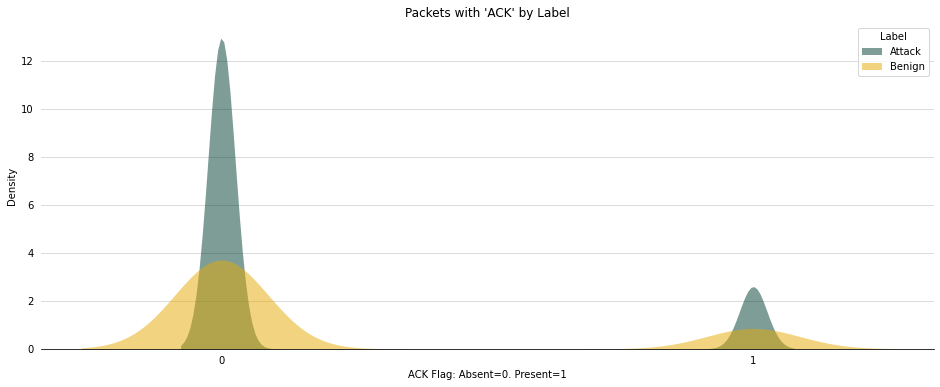

In [47]:
# Plot density of packets with 'ACK' by Label.

# Set figure size.
fig, ax = plt.subplots(figsize=(16,6))
ax.set_axisbelow(True)

sns.kdeplot(data=ddos_train, x="ACK Flag Count", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0)

# Add title and adjust axis labels.
plt.title("Packets with 'ACK' by Label")  # add a title
plt.xlabel("ACK Flag: Absent=0. Present=1")
plt.ylabel("Density")
plt.legend(legend_names, title="Label")
x_ticks = [0, 1]
plt.xticks(x_ticks, x_ticks)

# Hide bounding box and axis ticks.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y", color="lightgrey")
ax.tick_params(bottom=False,
               left=False,
               labelleft=True,
               labelbottom=True)
plt.show()

# Download plot.
# fig.savefig("packets_with_ack_single_plot.png", dpi=300)
# files.download("packets_with_ack_single_plot.png") 



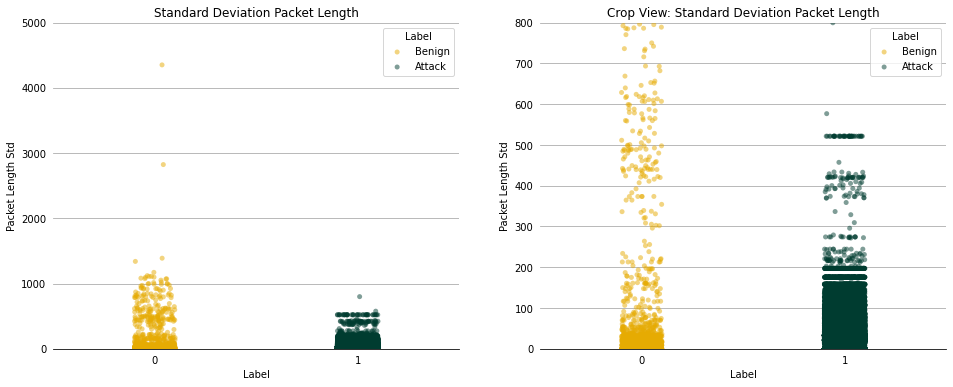

In [48]:
# Compare variation of standard deviation of packet length across Labels.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Axis 1 subplot.
sns.stripplot(data=ddos_train, x="Label", y="Packet Length Std", palette=[gold, dark_teal], alpha=0.5, ax=ax1)

# Add title and adjust axis labels.
ax1.set_ylim(0, 5000)
ax1.set_title("Standard Deviation Packet Length")  # Standard deviation length of a packet
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="darkgrey")
ax1.set_xlabel("Label")
ax1.set_ylabel("Packet Length Std")
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax1.legend(["Benign", "Attack"], title="Label")


# Axis 2 subplot.
sns.stripplot(data=ddos_train, x="Label", y="Packet Length Std", palette=[gold, dark_teal], alpha=0.5, ax=ax2)
# Add title and adjust axis labels.
ax2.set_ylim(0, 800)
ax2.set_title("Crop View: Standard Deviation Packet Length")
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="darkgrey")
ax2.set_xlabel("Label")
ax2.set_ylabel("Packet Length Std")
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax2.legend(["Benign", "Attack"], title="Label")

plt.show()

# Download plot.
# fig.savefig("packet_length_stripplot_multi.png", dpi=300)
# files.download("packet_length_stripplot_multi.png") 


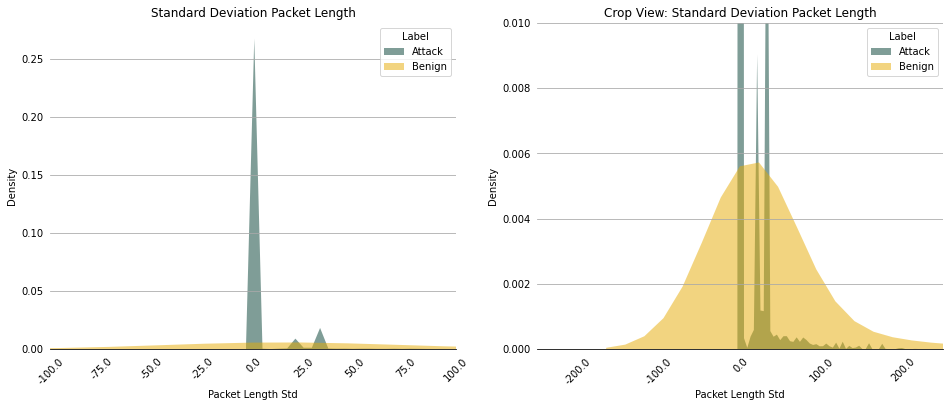

In [49]:
# Compare density of standard deviation of packet length across Labels.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Axis 1 subplot.
sns.kdeplot(data=ddos_train, x="Packet Length Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0, ax=ax1)

# Add title and adjust axis labels.
ax1.set_xlim(-100, 100)
ax1.set_title("Standard Deviation Packet Length")  # Standard deviation length of a packet
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="darkgrey")
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
ax1.set_xlabel("Packet Length Std")
ax1.set_ylabel("Density")
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax1.legend(legend_names, title="Label")


# Axis 2 subplot.
sns.kdeplot(data=ddos_train, x="Packet Length Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0, ax=ax2)

# Add title and adjust axis labels.
ax2.set_xlim(-250, 250)
ax2.set_ylim(0, 0.01)
ax2.set_title("Crop View: Standard Deviation Packet Length")
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="darkgrey")
ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
ax2.set_xlabel("Packet Length Std")
ax2.set_ylabel("Density")
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax2.legend(legend_names, title="Label")

plt.show()

# Download plot.
# fig.savefig("packet_length_density_multi.png", dpi=300)
# files.download("packet_length_density_multi.png") 

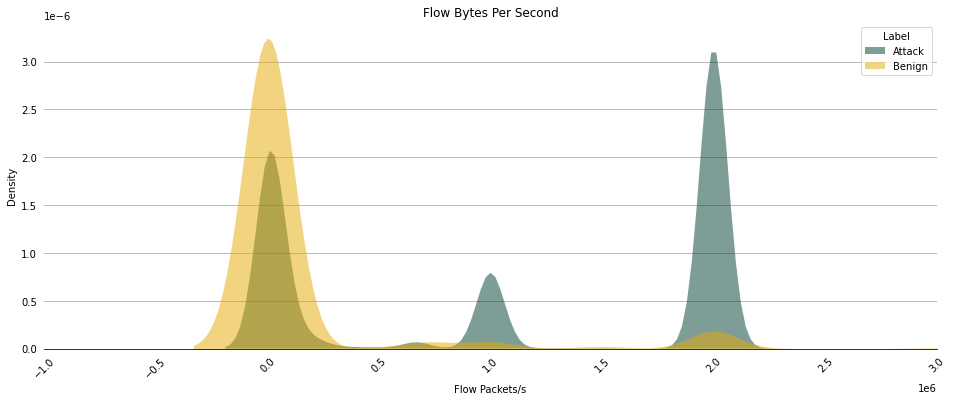

In [50]:
# Compare density of flow bytes/s across Labels.

# Set figure size.
fig, ax = plt.subplots(figsize=(16,6))
ax.set_axisbelow(True)

sns.kdeplot(data=ddos_train, x="Flow Packets/s", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0)

# Add title and adjust axis labels.
plt.title("Flow Bytes Per Second")  # Add title.
plt.legend(legend_names, title="Label")
plt.xlabel("Flow Packets/s")
plt.ylabel("Density")
plt.xlim(-1e6, 3e6)
plt.xticks(rotation = 45)
# Hide bounding box and axis ticks.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y", color="darkgrey")
ax.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)

plt.show()


# Download plot.
# fig.savefig("flow_bytes_per_second_multi.png", dpi=300)
# files.download("flow_bytes_per_second_multi.png") 


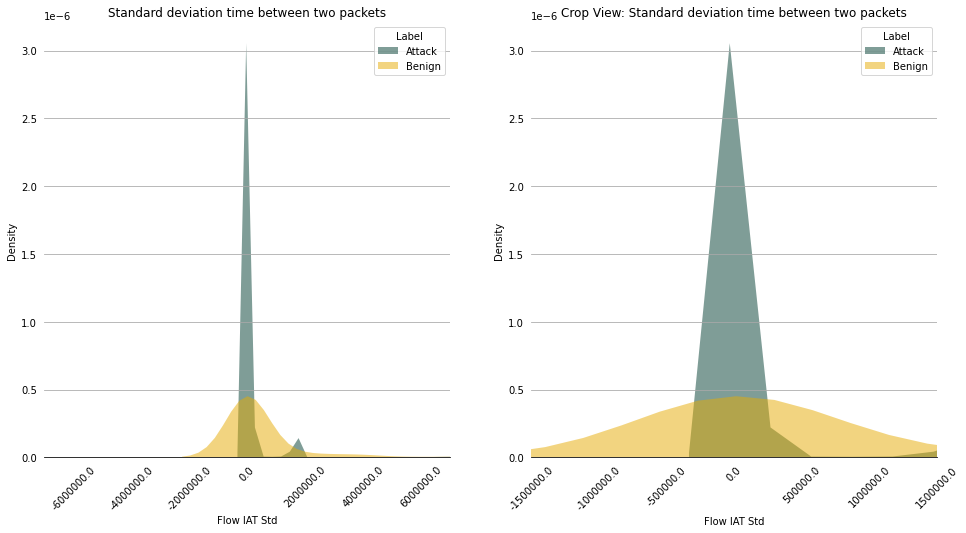

In [51]:
# Compare standard deviation of time between packets across Labels.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# Axis 1 subplot.
sns.kdeplot(data=ddos_train, x="Flow IAT Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0, ax=ax1)

# Add title and adjust axis labels.
ax1.set_xlim(-7000000, 7000000)
ax1.set_title("Standard deviation time between two packets")  # Standard deviation time between two packets sent in the flow
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="darkgrey")
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
ax1.set_xlabel("Flow IAT Std")
ax1.set_ylabel(None)
ax1.set_ylabel("Density")
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax1.legend(legend_names, title="Label")


# Axis 2 subplot.
sns.kdeplot(data=ddos_train, x="Flow IAT Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=0.5, linewidth=0, ax=ax2)

# Add title and adjust axis labels.
ax2.set_xlim(-1500000, 1500000)
#ax2.set_ylim(0, 0.5e-7)
ax2.set_title("Crop View: Standard deviation time between two packets")
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="darkgrey")
ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
ax2.set_xlabel("Flow IAT Std")
ax2.set_ylabel(None)
ax2.set_ylabel("Density")
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax2.legend(legend_names, title="Label")

plt.show()


# Download plot.
# fig.savefig("time_between_two_packets_multi.png", dpi=300)
# files.download("time_between_two_packets_multi.png") 


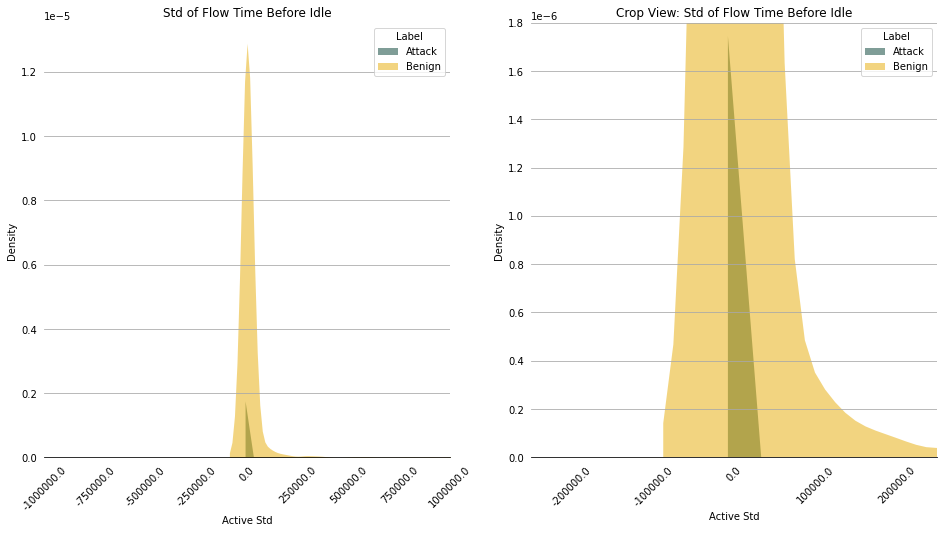

In [58]:
# Compare standard deviation of flow time before idle across Labels.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# Axis 1 subplot.
sns.kdeplot(data=ddos_train, x="Active Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=.5, linewidth=0, ax=ax1)

# Add title and adjust axis labels.
ax1.set_xlim(-1e6, 1e6)
ax1.set_title("Std of Flow Time Before Idle")
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="darkgrey")
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
ax1.set_xlabel("Active Std")
ax1.set_ylabel(None)
ax1.set_ylabel("Density")
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax1.legend(legend_names, title="Label")


# Axis 2 subplot.
sns.kdeplot(data=ddos_train, x="Active Std", hue=ddos_train["Label"].ravel(), fill=True, 
            palette=[gold, dark_teal], common_norm=False, alpha=0.5, linewidth=0, ax=ax2)

# Add title and adjust axis labels.
ax2.set_xlim(-250000, 250000)
ax2.set_ylim(0, 0.18e-5)
ax2.set_title("Crop View: Std of Flow Time Before Idle")
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="darkgrey")
ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
ax2.set_xlabel("Active Std")
ax2.set_ylabel(None)
ax2.set_ylabel("Density")
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)
ax2.legend(legend_names, title="Label")

plt.show()


# Download plot.
# fig.savefig("time_before_idle_multi.png", dpi=300)
# files.download("time_before_idle_multi.png") 


## **2.3: Divide and Scale data.**

### Divide into X and y

In [53]:
# CIC-DDoS2019 Data.

# Divide training data into features and target.
X_train = ddos_train.drop(["Label"], axis=1)
y_train = ddos_train["Label"].values.reshape(-1,1)

X_test = ddos_test.drop(["Label"], axis=1)
y_test = ddos_test["Label"].values.reshape(-1,1)

print(X_train.shape)
print(X_test.shape)

(651968, 76)
(266265, 76)


In [54]:
# CIC-IDS2017 Data.

# Slow DoS: Divide training data into features and target.
X_slow = slow_dos_IDS2017.drop(["Label"], axis=1)
y_slow = slow_dos_IDS2017["Label"].values.reshape(-1,1)

# Benign: Divide training data into features and target.
X_benign = benign_IDS2017.drop(["Label"], axis=1)
y_original_benign = benign_IDS2017["Label"].values.reshape(-1,1)

### Scale the data

In [55]:
scaler = MinMaxScaler()

# Train and test sets. 
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [56]:
# slow_dos_IDS2017.
X_slow_scale = scaler.fit_transform(X_slow)

# benign_IDS2017.
X_benign_scale = scaler.fit_transform(X_benign)

*****  
# **3: Create Models**     
*****      
The following models were used to obtain the results reported in Chapter 5 of the thesis document.

In [63]:
# Random Forest.
rf = RandomForestClassifier()  # Default values

# Naive Bayes model.
gnb = GaussianNB()  # Gaussian variant.
cnb = ComplementNB()  # Complement variant.

# Logistic Regression.
logit_reg = LogisticRegression(solver="sag", random_state=seed, max_iter=1000, class_weight="balanced")

# Linear Support Vector Machine Model.
lsvm = LinearSVC(random_state=seed, class_weight="balanced", max_iter=10)

*****  
# **4: Cross Validation Scores**     
*****   
The following carries out an evaluation of the models using a 5-fold cross validation for each of the metrics.           
The results are averaged across the two classes.     
         

Reference list of evaluation scores:     
https://scikit-learn.org/stable/modules/model_evaluation.html

In [60]:
# Create a stratified k-fold
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)  # Splits is number of folds.

# Create customer scorers. Allows 'adjusted' and 'average' parameters to be changed.
bal_acc_adj = make_scorer(balanced_accuracy_score, adjusted=True)
auc_macro = make_scorer(roc_auc_score, average="macro")

# Create Precision-Recall Curve. Info on sci-kit learn implementation: https://sinyi-chou.github.io/python-sklearn-precision-recall/ 
avg_precision_macro = make_scorer(average_precision_score, average="macro")

# Create list of scoring metrics for use in function.
scorers = ["accuracy", bal_acc_adj, auc_macro, avg_precision_macro, "precision_macro", "recall_macro", "f1_macro"]

# Create list of metric names for better legibility of results.
score_names = ["Accuracy", "Balanced Accuracy", "AUC", "PR-AUC", "Precision", "Recall", "F1-Score"]

In [61]:
# Create model to output multiple scores.
# cross_val_score only allows calculation of one score at a time.

def imbalance_scorers(model, X, y, strat_cv, scores, score_names, model_name):
  """
  Function to perform cross validation using multiple evaluation metrics.
    param model: Model
    param X: Features
    param y: Labels. 
    param strat_cv: stratified k-fold. 
    param scores: List of scorers to calculate. 
    param score_names: List of scorer names. 
    param model_name: List of model names.
    output: Prints average result of cross validation for each metric.
  """
  itr=0
  for score in scores:  # Loop through list of scorers.
    cv_scores = cross_val_score(model, X, y, scoring=score, cv=strat_cv, n_jobs=-1)  # Calculate 5-fold of each scorer in list.
    print(f"{model_name} {score_names[itr]}: {round(np.mean(cv_scores),3)} ({round(np.std(cv_scores),3)})")  # Print mean and sd of 5-fold results.
    itr+=1
    

## **4.1: CIC-DDoS2019**    
Cross validations for DDoS_combined_train and DDoS_combined_test from CIC-DDoS2019 dataset.

### Random Forest

In [ ]:
# Training dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(rf, X_train, y_train, skf, scorers, score_names, "RF Training Day")  # Calculate scores.
rf_time_elapsed_train = round((time.time() - start_time),3)  # Time elapsed.

RF Training Day Accuracy: 1.0 (0.0)
RF Training Day Balanced Accuracy: 0.995 (0.005)
RF Training Day AUC: 0.997 (0.002)
RF Training Day PR-AUC: 1.0 (0.0)
RF Training Day Precision: 0.994 (0.002)
RF Training Day Recall: 0.997 (0.002)
RF Training Day F1-Score: 0.995 (0.001)


In [ ]:
rf_time_elapsed_train  # Seconds.

1216.563

In [ ]:
# Test dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(rf, X_test, y_test, skf, scorers, score_names, "RF Test Day")  # Calculate scores.
rf_time_elapsed_test = round((time.time() - start_time),3)  # Time elapsed.

RF Test Day Accuracy: 1.0 (0.0)
RF Test Day Balanced Accuracy: 0.995 (0.004)
RF Test Day AUC: 0.997 (0.001)
RF Test Day PR-AUC: 1.0 (0.0)
RF Test Day Precision: 0.993 (0.003)
RF Test Day Recall: 0.997 (0.002)
RF Test Day F1-Score: 0.995 (0.002)


In [ ]:
rf_time_elapsed_test  # Seconds.

412.302

### Naive Bayes

In [ ]:
# Training dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(gnb, X_train_scale, y_train, skf, scorers, score_names, "GNB Training Day")  # Calculate scores.
gnb_time_elapsed_train = round((time.time() - start_time),3)  # Time elapsed.

GNB Training Day Accuracy: 0.977 (0.001)
GNB Training Day Balanced Accuracy: 0.963 (0.007)
GNB Training Day AUC: 0.981 (0.004)
GNB Training Day PR-AUC: 1.0 (0.0)
GNB Training Day Precision: 0.552 (0.001)
GNB Training Day Recall: 0.981 (0.004)
GNB Training Day F1-Score: 0.588 (0.002)


In [ ]:
gnb_time_elapsed_train  # Seconds.

27.134

In [ ]:
# Test dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(gnb, X_test_scale, y_test, skf, scorers, score_names, "GNB Test Day")  # Calculate scores.
gnb_time_elapsed_test = round((time.time() - start_time),3)  # Time elapsed.

GNB Test Day Accuracy: 0.971 (0.001)
GNB Test Day Balanced Accuracy: 0.959 (0.001)
GNB Test Day AUC: 0.979 (0.001)
GNB Test Day PR-AUC: 1.0 (0.0)
GNB Test Day Precision: 0.588 (0.002)
GNB Test Day Recall: 0.979 (0.001)
GNB Test Day F1-Score: 0.641 (0.004)


In [ ]:
gnb_time_elapsed_test  # Seconds.

9.416

### Logistic Regression     
**Note:** Takes over 4hrs to evaluate on X_train_scale and y_train.

In [ ]:
# Training dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(logit_reg, X_train_scale, y_train, skf, scorers, score_names, "Log Reg Training Day")  # Calculate scores.
logreg_time_elapsed_train = round((time.time() - start_time),3)  # Time elapsed.

Log Reg Training Day Accuracy: 0.992 (0.01)
Log Reg Training Day Balanced Accuracy: 0.979 (0.021)
Log Reg Training Day AUC: 0.989 (0.01)
Log Reg Training Day PR-AUC: 1.0 (0.0)
Log Reg Training Day Precision: 0.707 (0.117)
Log Reg Training Day Recall: 0.989 (0.01)
Log Reg Training Day F1-Score: 0.769 (0.119)


In [ ]:
logreg_time_elapsed_train  # Seconds.

14708.55

In [ ]:
# Test dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(logit_reg, X_test_scale, y_test, skf, scorers, score_names, "Log Reg Test Day")  # Calculate scores.
logreg_time_elapsed_test = round((time.time() - start_time),3)  # Time elapsed.

Log Reg Test Day Accuracy: 0.963 (0.07)
Log Reg Test Day Balanced Accuracy: 0.96 (0.069)
Log Reg Test Day AUC: 0.98 (0.035)
Log Reg Test Day PR-AUC: 1.0 (0.0)
Log Reg Test Day Precision: 0.811 (0.154)
Log Reg Test Day Recall: 0.98 (0.035)
Log Reg Test Day F1-Score: 0.842 (0.181)


In [ ]:
logreg_time_elapsed_test  # Seconds.

6460.886

### Linear SVM

In [ ]:
# Training dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(lsvm, X_train_scale, y_train, skf, scorers, score_names, "LSVM Training Day")  # Calculate scores.
lsvm_time_elapsed_train = round((time.time() - start_time),3)  # Time elapsed.

LSVM Training Day Accuracy: 0.999 (0.0)
LSVM Training Day Balanced Accuracy: 0.957 (0.012)
LSVM Training Day AUC: 0.978 (0.006)
LSVM Training Day PR-AUC: 1.0 (0.0)
LSVM Training Day Precision: 0.91 (0.01)
LSVM Training Day Recall: 0.978 (0.006)
LSVM Training Day F1-Score: 0.941 (0.004)


In [ ]:
lsvm_time_elapsed_train  # Seconds.

47.36

In [ ]:
# Test dataset evaluation scores.
start_time = time.time()  # Get start time.
imbalance_scorers(lsvm, X_test_scale, y_test, skf, scorers, score_names, "LSVM Test Day")  # Calculate scores.
lsvm_time_elapsed_test = round((time.time() - start_time),3)  # Time elapsed.

LSVM Test Day Accuracy: 1.0 (0.0)
LSVM Test Day Balanced Accuracy: 0.988 (0.007)
LSVM Test Day AUC: 0.994 (0.003)
LSVM Test Day PR-AUC: 1.0 (0.0)
LSVM Test Day Precision: 0.973 (0.004)
LSVM Test Day Recall: 0.994 (0.003)
LSVM Test Day F1-Score: 0.983 (0.002)


In [ ]:
lsvm_time_elapsed_test  # Seconds.

21.352

### Execution Time Comparison

In [ ]:
# DDoS_Train: Convert fit times to minutes.
# Notebook crashed so adding raw values manually.
rf_fit_time_train = round(1216.563 / 60, 2)
gnb_fit_time_train = round(27.134 / 60, 2)
logit_fit_time_train = round(14708.55 / 60, 2)
lsvm_fit_time_train = round(47.36 / 60, 2)

model_fit_times_train = [rf_fit_time_train, gnb_fit_time_train, logit_fit_time_train, lsvm_fit_time_train]
model_names = ["Random Forest", "Gaussian NB", "Logistic Regression", "Linear SVM"]

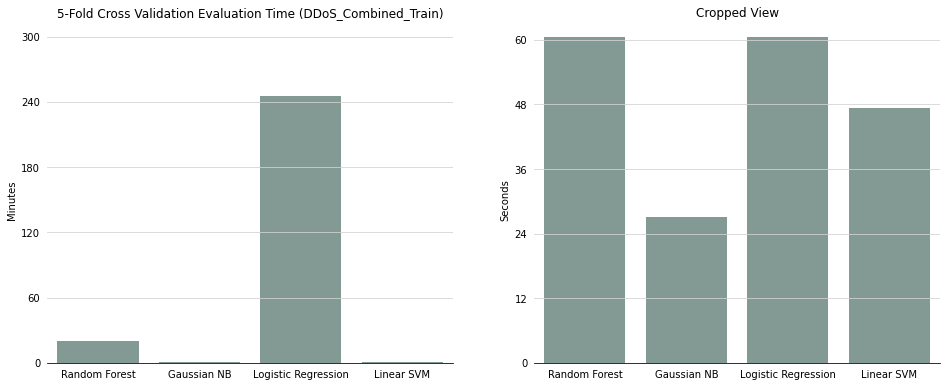

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot 5-Fold cross validation time for each model (DDoS_Combined_Train) data.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Axis 1 subplot.
sns.barplot(x=model_names, y=model_fit_times_train, fill=True, palette=[dark_teal], alpha=.5, linewidth=0, ax=ax1)

# Add title and adjust axis labels.
ax1.set_ylim(0, 300)
ax1.set_title("5-Fold Cross Validation Evaluation Time (DDoS_Combined_Train)", pad=20)
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="lightgrey")
ax1.set_ylabel("Minutes")
ax1.yaxis.set_ticks(np.arange(0, 301, 60))
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)


# Axis 2 subplot.
sns.barplot(x=model_names, y=model_fit_times_train, fill=True, palette=[dark_teal], alpha=.5, linewidth=0, ax=ax2)
# Add title and adjust axis labels.
ax2.set_ylim(0, 1.01)
ax2.set_title("Cropped View", pad=20)
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="lightgrey")
ax2.set_ylabel("Seconds")
seconds = ["0", "12","24","36","48", "60"]
ax2.set_yticklabels(seconds, minor=False)
ax2.yaxis.set_ticks(np.arange(0, 1.01, .2))
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)

plt.show()

# Download plot.
# fig.savefig("cross_val_time_ddos_train.png", dpi=300)
# files.download("cross_val_time_ddos_train.png") 

In [ ]:
# DDoS_Test: Convert fit times to minutes.
# Notebook crashed so adding raw values manually.
rf_fit_time_test = round(412.302 / 60, 2)
gnb_fit_time_test = round(9.416 / 60, 2)
logit_fit_time_test = round(6460.886 / 60, 2)
lsvm_fit_time_test = round(21.352 / 60, 2)

model_fit_times_test = [rf_fit_time_test, gnb_fit_time_test, logit_fit_time_test, lsvm_fit_time_test]

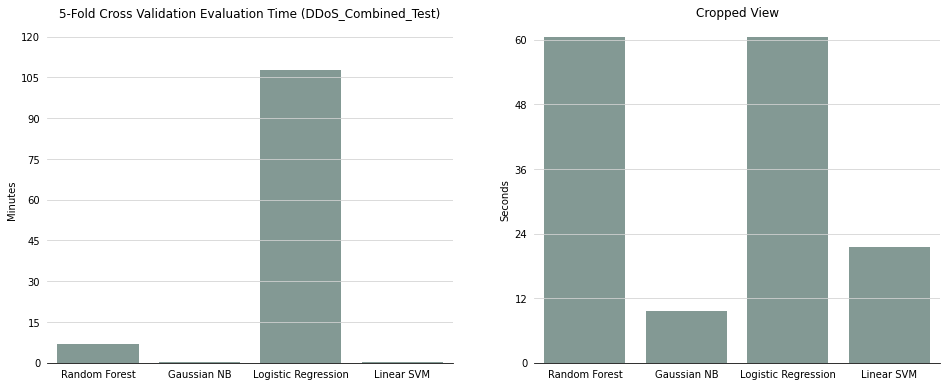

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot 5-Fold cross validation time for each model (DDoS_Combined_Test) data.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Axis 1 subplot.
sns.barplot(x=model_names, y=model_fit_times_test, fill=True, palette=[dark_teal], alpha=.5, linewidth=0, ax=ax1)

# Add title and adjust axis labels.
ax1.set_ylim(0, 120)
ax1.set_title("5-Fold Cross Validation Evaluation Time (DDoS_Combined_Test)", pad=20)
# Hide bounding box and axis ticks.
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.grid(axis="y", color="lightgrey")
ax1.set_ylabel("Minutes")
ax1.yaxis.set_ticks(np.arange(0, 121, 15))
ax1.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)

# Axis 2 subplot.
sns.barplot(x=model_names, y=model_fit_times_test, fill=True, palette=[dark_teal], alpha=.5, linewidth=0, ax=ax2)
# Add title and adjust axis labels.
ax2.set_ylim(0, 1.01)
ax2.set_title("Cropped View", pad=20)
# Hide bounding box and axis ticks.
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(axis="y", color="lightgrey")
ax2.set_ylabel("Seconds")
seconds = ["0", "12","24","36","48", "60"]
ax2.set_yticklabels(seconds, minor=False)
ax2.yaxis.set_ticks(np.arange(0, 1.01, .2))
ax2.tick_params(bottom=False, left=False, labelleft=True, labelbottom=True)

plt.show()

# Download plot.
# fig.savefig("cross_val_time_ddos_test.png", dpi=300)
# files.download("cross_val_time_ddos_test.png")  

## **4.2: CIC-IDS2017**    
Cross validations for slow_dos_IDS2017 from CIC-IDS2017 dataset.

### Random Forest

In [ ]:
# Random Forest: slow_dos_IDS2017
imbalance_scorers(rf, X_slow, y_slow, skf, scorers, score_names, "RF slow_dos")

RF slow_dos Accuracy: 1.0 (0.0)
RF slow_dos Balanced Accuracy: 0.996 (0.001)
RF slow_dos AUC: 0.998 (0.001)
RF slow_dos PR-AUC: 0.988 (0.002)
RF slow_dos Precision: 0.996 (0.001)
RF slow_dos Recall: 0.998 (0.0)
RF slow_dos F1-Score: 0.997 (0.001)


### Naive Bayes

In [64]:
# GNB: slow_dos_IDS2017
imbalance_scorers(cnb, X_slow_scale, y_slow, skf, scorers, score_names, "CNB slow_dos")

CNB slow_dos Accuracy: 0.913 (0.001)
CNB slow_dos Balanced Accuracy: 0.589 (0.004)
CNB slow_dos AUC: 0.795 (0.002)
CNB slow_dos PR-AUC: 0.126 (0.001)
CNB slow_dos Precision: 0.584 (0.001)
CNB slow_dos Recall: 0.795 (0.002)
CNB slow_dos F1-Score: 0.617 (0.001)


### Logistic Regression

In [ ]:
# Logistic Regression: slow_dos_IDS2017
imbalance_scorers(logit_reg, X_slow_scale, y_slow, skf, scorers, score_names, "Log Reg slow_dos")

Log Reg slow_dos Accuracy: 0.973 (0.002)
Log Reg slow_dos Balanced Accuracy: 0.953 (0.006)
Log Reg slow_dos AUC: 0.976 (0.003)
Log Reg slow_dos PR-AUC: 0.474 (0.022)
Log Reg slow_dos Precision: 0.741 (0.011)
Log Reg slow_dos Recall: 0.976 (0.003)
Log Reg slow_dos F1-Score: 0.816 (0.01)


### Linear SVM

In [ ]:
# Linear SVM: slow_dos_IDS2017
imbalance_scorers(lsvm, X_slow_scale, y_slow, skf, scorers, score_names, "LSVM slow_dos")

LSVM slow_dos Accuracy: 0.993 (0.003)
LSVM slow_dos Balanced Accuracy: 0.879 (0.063)
LSVM slow_dos AUC: 0.939 (0.031)
LSVM slow_dos PR-AUC: 0.761 (0.066)
LSVM slow_dos Precision: 0.93 (0.041)
LSVM slow_dos Recall: 0.939 (0.031)
LSVM slow_dos F1-Score: 0.932 (0.022)


*****  
# **5: Cross Validation Confusion Matrix** 
*****          
- "Specificity_TNR" is predicted TN (0) compared to actual negative.       
- "Sensitivity_TPR" is predicted TP (1) compared to actual positive.
- "Precision_benign" is predicted TN (0) compared to overall predicted negative.     
- "Precision_attack" is predicted TP (1) compared to overall predicted positve.     

In [67]:
# Suppress convergene warning for Logistic Regression and LSVM.
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [66]:
# Scikit Learn confusion matrix layout.

# [ TN | FP ]
# [ Fn | TP ]

In [65]:
# Original from documentation: https://scikit-learn.org/stable/modules/model_evaluation.html#using-multiple-metric-evaluation


def confusion_matrix_scorer(clf, X, y):
  """
  Function is a custom scorer passed to 'cross_validate'.
    param clf: Model
    param X: Features
    param y: Ground truth labels. 
    return: Raw results of confusion matrix and individual class metrics.
  """
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  diag = cm.diagonal()/(cm.sum(axis=0))
  diag_recall = cm.diagonal()/(cm.sum(axis=1))  # Axis=1 gives same value as 'recall' with average=None.
  diag_precision = cm.diagonal()/(cm.sum(axis=0))  # Axis=0 gives same value as 'precision' with average=None.

  return {"specificity_TNR": diag_recall[0],
          "sensitivity_TPR": diag_recall[1], 
          "precision_benign": diag_precision[0],  # Negative class (0)
          "precision_attack": diag_precision[1],  # Positive class (1)
          'tn': cm[0, 0], 'fp': cm[0, 1],
          'fn': cm[1, 0], 'tp': cm[1, 1]}  
       

In [68]:
def print_matrix_scores(matrix_scores, matrix_metrics, names):
  """
  Function to print results of 'cross validate' using 'confusion_matrix_scorer' as scorer.
    param matrix_scores: Returned object from 'cross_validate'.
    param matrix_metrics: Metrics to select from dictionary returned by 'confusion_matrix_scorer'.
    param names: Metric names for concise print. 
    output: Prints TNR, TPR, pr_benign, pr_attack to console.
  """
  itr=0
  for i in matrix_metrics:
    #print(f"{round(np.mean(matrix_scores[i]),3)} ")
    print(f"{names[itr]}:  {round(np.mean(matrix_scores[i]),3)} ")
    itr+=1

In [69]:
matrix_metrics = ["test_specificity_TNR", "test_sensitivity_TPR", "test_precision_benign", "test_precision_attack"]
metrics_names = ["specificity_TNR", "sensitivity_TPR", "precision_benign", "precision_attack"]

## **5.1: CIC-DDoS2019**    
Confusion Matrix cross validations for ddos_combined_train and ddos_combined_test from CIC-DDoS2019 dataset.

### Random Forest

In [70]:
# DDoS_combined_train
cmatrix_rf_train = cross_validate(rf, X_train, y_train.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_rf_train, matrix_metrics, metrics_names)

specificity_TNR:  0.993 
sensitivity_TPR:  1.0 
precision_benign:  0.958 
precision_attack:  1.0 


In [ ]:
# DDoS_combined_test
cmatrix_rf_test = cross_validate(rf, X_test, y_test.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_rf_test, matrix_metrics, metrics_names)

specificity_TNR:  0.993 
sensitivity_TPR:  1.0 
precision_benign:  0.977 
precision_attack:  1.0 


In [71]:
# Inspect raw results for each fold.
cmatrix_rf_train

{'fit_time': array([47.00281596, 48.70529103, 43.35401034, 41.45021439, 37.23616552]),
 'score_time': array([0.71684527, 0.70232606, 0.70273018, 0.78643608, 0.8494935 ]),
 'test_specificity_TNR': array([0.98837209, 0.99709302, 0.98837209, 0.99709302, 0.9941691 ]),
 'test_sensitivity_TPR': array([0.99979239, 1.        , 0.99998462, 0.99996924, 0.9996386 ]),
 'test_precision_benign': array([0.92643052, 1.        , 0.99415205, 0.98847262, 0.87886598]),
 'test_precision_attack': array([0.99996924, 0.99999231, 0.99996924, 0.99999231, 0.99998462]),
 'test_tn': array([340, 343, 340, 343, 341]),
 'test_fp': array([4, 1, 4, 1, 2]),
 'test_fn': array([27,  0,  2,  4, 47]),
 'test_tp': array([130023, 130050, 130048, 130045, 130003])}

### Naive Bayes

In [ ]:
# DDoS_combined_train
cmatrix_gnb_train = cross_validate(gnb, X_train_scale, y_train.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_gnb_train, matrix_metrics, metrics_names)

specificity_TNR:  0.985 
sensitivity_TPR:  0.971 
precision_benign:  0.446 
precision_attack:  1.0 


In [ ]:
# DDoS_combined_test
cmatrix_gnb_test = cross_validate(gnb, X_test_scale, y_test.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_gnb_test, matrix_metrics, metrics_names)

specificity_TNR:  0.989 
sensitivity_TPR:  0.969 
precision_benign:  0.472 
precision_attack:  1.0 


### Logistic Regression

In [ ]:
# DDoS_combined_train (Not converging).
cmatrix_logit_train = cross_validate(logit_reg, X_train_scale, y_train.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_logit_train, matrix_metrics, metrics_names)

specificity_TNR:  0.992 
sensitivity_TPR:  0.993 
precision_benign:  0.514 
precision_attack:  1.0 


In [ ]:
# DDoS_combined_test (Not converging).
cmatrix_logit_test = cross_validate(logit_reg, X_test_scale, y_test.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_logit_test, matrix_metrics, metrics_names)

specificity_TNR:  0.987 
sensitivity_TPR:  0.996 
precision_benign:  0.796 
precision_attack:  1.0 


### Linear SVM

In [ ]:
# DDoS_combined_train (Not converging).
cmatrix_lsvm_train = cross_validate(lsvm, X_train_scale, y_train.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_lsvm_train, matrix_metrics, metrics_names)

specificity_TNR:  0.967 
sensitivity_TPR:  0.999 
precision_benign:  0.766 
precision_attack:  1.0 


In [ ]:
# DDoS_combined_test (Not converging).
cmatrix_lsvm_test = cross_validate(lsvm, X_test_scale, y_test.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_lsvm_test, matrix_metrics, metrics_names)

specificity_TNR:  0.988 
sensitivity_TPR:  1.0 
precision_benign:  0.94 
precision_attack:  1.0 


## **5.2: CIC-IDS2017**    
Confusion Matrix cross validations for slow_dos_IDS2017 from CIC-IDS2017 dataset.

### Random Forest

In [ ]:
# slow_dos_IDS2017
cmatrix_rf_slow = cross_validate(rf, X_slow, y_slow.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_rf_slow, matrix_metrics, metrics_names)

specificity_TNR:  1.0 
sensitivity_TPR:  0.908 
precision_benign:  0.998 
precision_attack:  0.988 


In [ ]:
# Inspect raw results.
cmatrix_rf_slow

{'fit_time': array([70.48389363, 73.47971153, 74.38643837, 81.47990346, 77.73658037]),
 'score_time': array([0.73539448, 0.8017416 , 0.74482703, 0.69012952, 0.65108418]),
 'test_specificity_TNR': array([0.99988628, 0.99989765, 0.99995451, 0.9994314 , 0.99952238]),
 'test_sensitivity_TPR': array([0.8853475 , 1.        , 0.9645861 , 0.85878707, 0.82912793]),
 'test_precision_benign': array([0.99706303, 1.        , 0.99909104, 0.99638342, 0.99562755]),
 'test_precision_attack': array([0.99502488, 0.99603175, 0.99816766, 0.97487437, 0.97806789]),
 'test_tn': array([87927, 87928, 87933, 87886, 87894]),
 'test_fp': array([10,  9,  4, 50, 42]),
 'test_fn': array([259,   0,  80, 319, 386]),
 'test_tp': array([2000, 2259, 2179, 1940, 1873])}

### Naive Bayes

In [ ]:
# slow_dos_IDS2017 - Complement Naive Bayes.
cmatrix_cnb_slow = cross_validate(cnb, X_slow_scale, y_slow.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_cnb_slow, matrix_metrics, metrics_names)

specificity_TNR:  0.909 
sensitivity_TPR:  0.67 
precision_benign:  0.991 
precision_attack:  0.296 


### Logistic Regression

In [ ]:
# slow_dos_IDS2017
cmatrix_logit_slow = cross_validate(logit_reg, X_slow_scale, y_slow.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_logit_slow, matrix_metrics, metrics_names)

specificity_TNR:  0.97 
sensitivity_TPR:  0.939 
precision_benign:  0.998 
precision_attack:  0.477 


### Linear SVM

In [ ]:
# slow_dos_IDS2017
cmatrix_lsvm_slow = cross_validate(lsvm, X_slow_scale, y_slow.ravel(), cv=5, scoring=confusion_matrix_scorer)  # Uses stratified kFold by default.
print_matrix_scores(cmatrix_lsvm_slow, matrix_metrics, metrics_names)

specificity_TNR:  0.995 
sensitivity_TPR:  0.843 
precision_benign:  0.996 
precision_attack:  0.82 


*****           
# **6: Train / Test different datasets.**   
Fit to DDoS_combined_train and make predictions on ddos_combined_test, slow_dos_IDS2017 and benign_IDS2017.

*****         

In [ ]:
def eval_unseen_dataset(model, X, y, unseen_dataset, seed_num, itr, frac, scale, adj, model_name):
  """
  Function to perform cross validation on two different data sources.
    param model: Model
    param X: Features
    param y: Labels
    param unseen_dataset: Dataset for evaluation
    param seed_number: Seed number
    param itr: Number of folds
    param frac: Fraction of unseen dataset to use
    param scale: Perform scaling on unseen data [Bool]
    param adj: Adjust balanced accuracy score [Bool]
    param model_name: Name of model [String]
    output: Average cross validation and confusion matrix scores
  """
  seed_num = seed_num  # Set seed for reproducibility.
  model.fit(X, y.ravel())  # Fit model to training data.

  acc = []
  bal_acc = []
  auc = []
  pr_auc = []
  precision = []
  recall = []
  f1 = []
  tnr = []
  tpr = []
  pr_neg = []
  pr_pos = []

  # Perform cross validation.
  for i in range(itr):
    np.random.seed(seed_num)  # 17
    seed = int(np.random.randint(1, 100, size=1)) 

    # Sample from unseen dataset.
    sampled_dataset = unseen_dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=seed))
    # Divide into x and y
    X_unseen = sampled_dataset.drop(["Label"], axis=1)
    y_unseen = sampled_dataset["Label"].values.reshape(-1,1)

    # Perform scaling on unseen data if True.Make predictions.
    if scale == True:
      X_unseen_scale = scaler.fit_transform(X_unseen)
      y_pred = model.predict(X_unseen_scale) 
    else:
      y_pred = model.predict(X_unseen)

    # Append evaluation results to lists.
    acc.append(accuracy_score(y_unseen, y_pred))
    bal_acc.append(balanced_accuracy_score(y_unseen, y_pred, adjusted=adj))
    auc.append(roc_auc_score(y_unseen, y_pred, average="macro"))
    pr_auc.append(average_precision_score(y_unseen, y_pred, average="macro"))
    # Calculate precision, recall and f1.
    pr_rc_f1 = precision_recall_fscore_support(y_unseen, y_pred, average='macro', zero_division=0)
    precision.append(pr_rc_f1[0])
    recall.append(pr_rc_f1[1])
    f1.append(pr_rc_f1[2])

    # Calculate confusion matrix metrics (Individual classes).
    matrix = confusion_matrix(y_unseen, y_pred)
    diag_recall = matrix.diagonal()/matrix.sum(axis=1)  # Sum along columns of matrix.
    diag_precision = matrix.diagonal()/matrix.sum(axis=0)  # Sum along rows of matrix.  
    tnr.append(diag_recall[0])
    tpr.append(diag_recall[1]) 
    pr_neg.append(diag_precision[0]) 
    pr_pos.append(diag_precision[1])
    seed_num+=7  # Update seed to sample different subset of unseen data.

  # Print average score and standard deviation for each metric.
  print(f"{model_name} Accuracy: {round(np.mean(acc),3)} ({round(np.std(acc),3)})")
  print(f"{model_name} Balanced Accuracy: {round(np.mean(bal_acc),3)} ({round(np.std(bal_acc),3)})")
  print(f"{model_name} AUC: {round(np.mean(auc),3)} ({round(np.std(auc),3)})")
  print(f"{model_name} PR-AUC: {round(np.mean(pr_auc),3)} ({round(np.std(pr_auc),3)})")
  print(f"{model_name} Precision: {round(np.mean(precision),3)} ({round(np.std(precision),3)})")
  print(f"{model_name} Recall: {round(np.mean(recall),3)} ({round(np.std(recall),3)})")
  print(f"{model_name} F1-Score: {round(np.mean(f1),3)} ({round(np.std(f1),3)})")
  print(f"{model_name} Specificity (TNR): {round(np.mean(tnr),3)} ({round(np.std(tnr),3)})")
  print(f"{model_name} Sensitivity / Recall (TPR): {round(np.mean(tpr),3)} ({round(np.std(tpr),3)})")
  print(f"{model_name} Precision (negative class): {round(np.mean(pr_neg),3)} ({round(np.std(pr_neg),3)})")
  print(f"{model_name} Precision (positive class): {round(np.mean(pr_pos),3)} ({round(np.std(pr_pos),3)})")
  

## **6.1: Fit DDoS train. Predict DDoS Test** 

### Random Forest

In [ ]:
# ddos_combined_train / ddos_combined_test.
eval_unseen_dataset(rf, X_train_scale, y_train, ddos_test, seed, 1, 1, True, True, "RF Train/Test Days")  # Run once as test set is 30% of training set.

RF Train/Test Days Accuracy: 0.999 (0.0)
RF Train/Test Days Balanced Accuracy: 0.966 (0.0)
RF Train/Test Days AUC: 0.983 (0.0)
RF Train/Test Days PR-AUC: 1.0 (0.0)
RF Train/Test Days Precision: 0.922 (0.0)
RF Train/Test Days Recall: 0.983 (0.0)
RF Train/Test Days F1-Score: 0.951 (0.0)
RF Train/Test Days Specificity (TNR): 0.967 (0.0)
RF Train/Test Days Sensitivity / Recall (TPR): 0.999 (0.0)
RF Train/Test Days Precision (negative class): 0.845 (0.0)
RF Train/Test Days Precision (positive class): 1.0 (0.0)


### Naive Bayes

In [ ]:
# ddos_combined_train / ddos_combined_test.
eval_unseen_dataset(cnb, X_train_scale, y_train, ddos_test, seed, 1, 1, True, True, "CNB Train/Test Days")

CNB Train/Test Days Accuracy: 0.856 (0.0)
CNB Train/Test Days Balanced Accuracy: 0.852 (0.0)
CNB Train/Test Days AUC: 0.926 (0.0)
CNB Train/Test Days PR-AUC: 0.999 (0.0)
CNB Train/Test Days Precision: 0.521 (0.0)
CNB Train/Test Days Recall: 0.926 (0.0)
CNB Train/Test Days F1-Score: 0.501 (0.0)
CNB Train/Test Days Specificity (TNR): 0.996 (0.0)
CNB Train/Test Days Sensitivity / Recall (TPR): 0.856 (0.0)
CNB Train/Test Days Precision (negative class): 0.041 (0.0)
CNB Train/Test Days Precision (positive class): 1.0 (0.0)


### Logistic Regression

In [ ]:
# ddos_combined_train / ddos_combined_test.
eval_unseen_dataset(logit_reg, X_train_scale, y_train, ddos_test, seed, 1, 1, True, False, "Log Reg Train/Test Days")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Log Reg Train/Test Days Accuracy: 0.994 (0.0)
Log Reg Train/Test Days Balanced Accuracy: 0.997 (0.0)
Log Reg Train/Test Days AUC: 0.997 (0.0)
Log Reg Train/Test Days PR-AUC: 1.0 (0.0)
Log Reg Train/Test Days Precision: 0.752 (0.0)
Log Reg Train/Test Days Recall: 0.997 (0.0)
Log Reg Train/Test Days F1-Score: 0.833 (0.0)
Log Reg Train/Test Days Specificity (TNR): 1.0 (0.0)
Log Reg Train/Test Days Sensitivity / Recall (TPR): 0.994 (0.0)
Log Reg Train/Test Days Precision (negative class): 0.503 (0.0)
Log Reg Train/Test Days Precision (positive class): 1.0 (0.0)


### Linear SVM

In [ ]:
# ddos_combined_train / ddos_combined_test.
eval_unseen_dataset(lsvm, X_train_scale, y_train, ddos_test, seed, 1, 1, True, True, "LSVM Train/Test Days")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LSVM Train/Test Days Accuracy: 1.0 (0.0)
LSVM Train/Test Days Balanced Accuracy: 0.963 (0.0)
LSVM Train/Test Days AUC: 0.981 (0.0)
LSVM Train/Test Days PR-AUC: 1.0 (0.0)
LSVM Train/Test Days Precision: 0.979 (0.0)
LSVM Train/Test Days Recall: 0.981 (0.0)
LSVM Train/Test Days F1-Score: 0.98 (0.0)
LSVM Train/Test Days Specificity (TNR): 0.963 (0.0)
LSVM Train/Test Days Sensitivity / Recall (TPR): 1.0 (0.0)
LSVM Train/Test Days Precision (negative class): 0.959 (0.0)
LSVM Train/Test Days Precision (positive class): 1.0 (0.0)


## **6.2: Fit DDoS Train. Predict Slow DoS** 

### Random Forest

In [ ]:
# ddos_combined_train / slow_dos_IDS2017.
eval_unseen_dataset(rf, X_train_scale, y_train, slow_dos_IDS2017, seed, 5, 0.58, True, True, "RF")

RF Accuracy: 0.801 (0.004)
RF Balanced Accuracy: 0.546 (0.006)
RF AUC: 0.773 (0.003)
RF PR-AUC: 0.072 (0.001)
RF Precision: 0.54 (0.001)
RF Recall: 0.773 (0.003)
RF F1-Score: 0.522 (0.002)
RF Specificity (TNR): 0.802 (0.004)
RF Sensitivity / Recall (TPR): 0.744 (0.005)
RF Precision (negative class): 0.992 (0.0)
RF Precision (positive class): 0.088 (0.001)


### Naive Bayes

In [ ]:
# ddos_combined_train / slow_dos_IDS2017.
eval_unseen_dataset(gnb, X_train_scale, y_train, slow_dos_IDS2017, seed, 5, 0.58, True, False, "GNB")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


GNB Accuracy: 0.975 (0.0)
GNB Balanced Accuracy: 0.5 (0.0)
GNB AUC: 0.5 (0.0)
GNB PR-AUC: 0.025 (0.0)
GNB Precision: 0.487 (0.0)
GNB Recall: 0.5 (0.0)
GNB F1-Score: 0.494 (0.0)
GNB Specificity (TNR): 1.0 (0.0)
GNB Sensitivity / Recall (TPR): 0.0 (0.0)
GNB Precision (negative class): 0.975 (0.0)
GNB Precision (positive class): nan (nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


### Logistic Regression

In [ ]:
# ddos_combined_train / slow_dos_IDS2017.
eval_unseen_dataset(logit_reg, X_train_scale, y_train, slow_dos_IDS2017, seed, 5, 0.58, True, False, "Log Reg")

Log Reg Accuracy: 0.816 (0.0)
Log Reg Balanced Accuracy: 0.536 (0.001)
Log Reg AUC: 0.536 (0.001)
Log Reg PR-AUC: 0.028 (0.0)
Log Reg Precision: 0.506 (0.0)
Log Reg Recall: 0.536 (0.001)
Log Reg F1-Score: 0.48 (0.0)
Log Reg Specificity (TNR): 0.831 (0.0)
Log Reg Sensitivity / Recall (TPR): 0.242 (0.003)
Log Reg Precision (negative class): 0.977 (0.0)
Log Reg Precision (positive class): 0.035 (0.0)


### Linear SVM

In [ ]:
# ddos_combined_train / slow_dos_IDS2017.
eval_unseen_dataset(lsvm, X_train_scale, y_train, slow_dos_IDS2017, seed, 5, 0.58, True, True, "LSVM")

LSVM Accuracy: 0.621 (0.029)
LSVM Balanced Accuracy: 0.069 (0.031)
LSVM AUC: 0.534 (0.015)
LSVM PR-AUC: 0.027 (0.001)
LSVM Precision: 0.504 (0.002)
LSVM Recall: 0.534 (0.015)
LSVM F1-Score: 0.409 (0.013)
LSVM Specificity (TNR): 0.626 (0.03)
LSVM Sensitivity / Recall (TPR): 0.443 (0.025)
LSVM Precision (negative class): 0.978 (0.001)
LSVM Precision (positive class): 0.03 (0.002)


## **6.3: Fit DDoS Train. Predict Benign** 

### Random Forest

In [ ]:
# ddos_combined_train / benign_IDS2017.
rf.fit(X_train_scale, y_train.ravel())  # Fit to ddos_combined_train.
y_pred_benign_rf = rf.predict(X_benign)  # Make predictions on benign dataset.

# Calculate accuracy.
print("Correct train pred:  ", sum(y_pred_benign_rf == 0))
print("Incorrect train pred:", sum(y_pred_benign_rf == 1))
print("RF Accuracy:         ", round(accuracy_score(y_original_benign, y_pred_benign_rf),3))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Correct train pred:   455484
Incorrect train pred: 73997
RF Accuracy:          0.86


### Naive Bayes

In [ ]:
# ddos_combined_train / benign_IDS2017.
gnb.fit(X_train_scale, y_train.ravel())  # Fit to ddos_combined_train.
y_pred_benign_gnb = gnb.predict(X_benign_scale)  # Make predictions on benign dataset.

# Calculate accuracy.
print("Correct train pred:  ", sum(y_pred_benign_gnb == 0))
print("Incorrect train pred:", sum(y_pred_benign_gnb == 1))
print("GNB Accuracy:         ", round(accuracy_score(y_original_benign, y_pred_benign_gnb),3))

Correct train pred:   529481
Incorrect train pred: 0
GNB Accuracy:          1.0


### Logistic Regression

In [ ]:
# ddos_combined_train / benign_IDS2017.
logit_reg.fit(X_train_scale, y_train.ravel())  # Fit to ddos_combined_train.
y_pred_benign_logit = logit_reg.predict(X_benign_scale)  # Make predictions on benign dataset.

# Calculate accuracy.
print("Correct train pred:  ", sum(y_pred_benign_logit == 0))
print("Incorrect train pred:", sum(y_pred_benign_logit == 1))
print("Logit Reg Accuracy:  ", round(accuracy_score(y_original_benign, y_pred_benign_logit),3))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Correct train pred:   452171
Incorrect train pred: 77310
Logit Reg Accuracy:   0.854


### Linear SVM

In [ ]:
# ddos_combined_train / benign_IDS2017.
lsvm.fit(X_train_scale, y_train.ravel())  # Fit to ddos_combined_train.
y_pred_benign_lsvm = lsvm.predict(X_benign_scale)  # Make predictions on benign dataset.

# Calculate accuracy.
print("Correct train pred:  ", sum(y_pred_benign_lsvm == 0))
print("Incorrect train pred:", sum(y_pred_benign_lsvm == 1))
print("LSVM Accuracy:       ", round(accuracy_score(y_original_benign, y_pred_benign_lsvm),3))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Correct train pred:   342312
Incorrect train pred: 187169
LSVM Accuracy:        0.647
